Vision por computador: Taller 3

Presentado por: Dany Conrado Palacio, Manuela Ramos Ospina y Sebastián Escobar Pajoy

Importacion de clip

In [ ]:
import clip
import torch
from PIL import Image
import os
import numpy as np
import random

# Cargar modelo CLIP
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device)


Generacion de la base de imagenes con un 25% de la base original

In [3]:
import os
from PIL import Image

# Función para cargar imágenes desde subcarpetas
def load_images_from_subfolders(base_dir):
    images = []
    image_paths = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files[:int(len(files)/4)]:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Asegúrate de que sean imágenes válidas
                img_path = os.path.join(root, file)
                image_paths.append(img_path)
                
                # Usamos el bloque 'with' para garantizar que la imagen se cierre después de abrirla
                with Image.open(img_path) as img:
                    images.append(img.copy())  # Usamos .copy() para asegurarnos de que la imagen no se cierre prematuramente
    
    return images, image_paths

# Cargar imágenes de la carpeta 256_ObjectCategories
base_dir = '256_ObjectCategories'
images, image_paths = load_images_from_subfolders(base_dir)

# Verificar cuántas imágenes se cargaron
print(f"Se cargaron {len(images)} imágenes")



Se cargaron 7557 imágenes


Generacion de la base vectorial (Embeddings de las imagenes)

In [6]:
import numpy as np

# Función para generar embeddings de imágenes
def generate_image_embeddings(images):
    image_embeddings = []
    ccc=0
    for image in images:
        ccc+=1
        print(ccc)
        # Preprocesar y generar el embedding de la imagen
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        
        image_embeddings.append(image_features.cpu().numpy())
    
    return np.array(image_embeddings)

# Generar los embeddings de las imágenes
image_embeddings = generate_image_embeddings(images)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Generacion de embeddings de Texto

In [18]:
# Función para generar el embedding de una consulta de texto
def get_text_embedding(text):
    text_input = clip.tokenize([text]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    
    return text_features.cpu().numpy()

# Ejemplo de texto de consulta
query_text = "a picture of a blue flag"

# Generar el embedding del texto
text_embedding = get_text_embedding(query_text)


Comparacion de embeddings de texto con imagenes mediante la similitud coseno

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Función para realizar la búsqueda de imágenes más similares
def search_images_by_text(query_text, image_embeddings, image_paths):
    # Obtener el embedding de la consulta de texto
    text_embedding = get_text_embedding(query_text)
    
    # Asegurarse de que el embedding de texto sea 2D
    text_embedding = text_embedding.reshape(1, -1)
    
    # Asegurarse de que los embeddings de imagen sean 2D
    image_embeddings = image_embeddings.reshape(len(image_embeddings), -1)
    
    # Calcular la similitud coseno entre el texto y las imágenes
    similarities = cosine_similarity(text_embedding, image_embeddings)
    
    # Ordenar las imágenes según la similitud (de mayor a menor)
    sorted_indices = np.argsort(similarities[0])[::-1]
    
    # Devolver las rutas de las imágenes más similares
    return [image_paths[i] for i in sorted_indices]

# Realizar la búsqueda de imágenes más similares
sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)

# Mostrar las 5 imágenes más similares
print("Las 5 imágenes más similares son:")
for path in sorted_image_paths[:5]:
    print(path)


Las 5 imágenes más similares son:
256_ObjectCategories\002.american-flag\002_0019.jpg
256_ObjectCategories\002.american-flag\002_0004.jpg
256_ObjectCategories\149.necktie\149_0012.jpg
256_ObjectCategories\188.smokestack\188_0022.jpg
256_ObjectCategories\123.ketch-101\123_0006.jpg


Recuperacion de las 5 imagenes mas similares

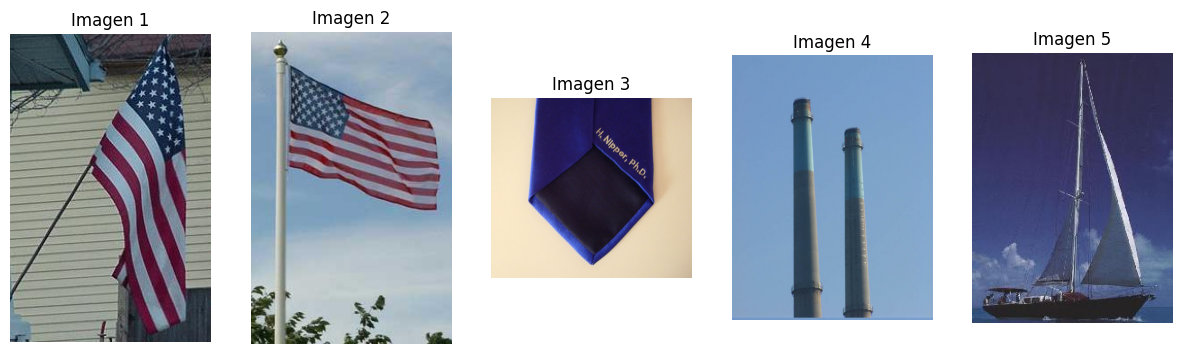

In [20]:
# Mostrar las 5 imágenes más similares
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()


Ejemplos con otras querys

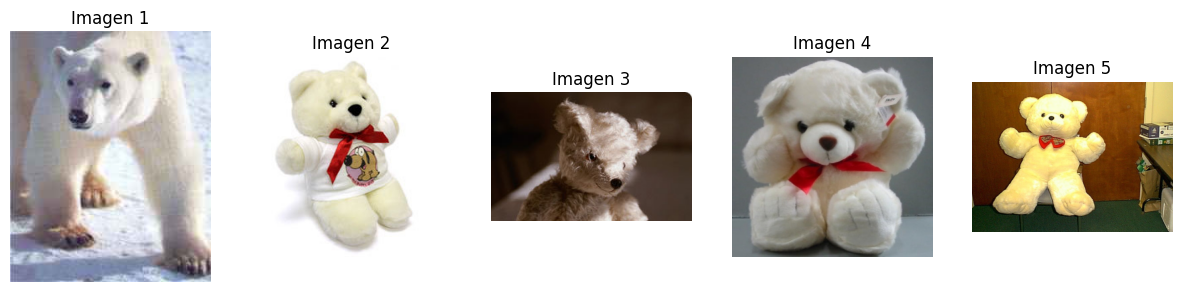

In [13]:
query_text = "White bear"
sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()


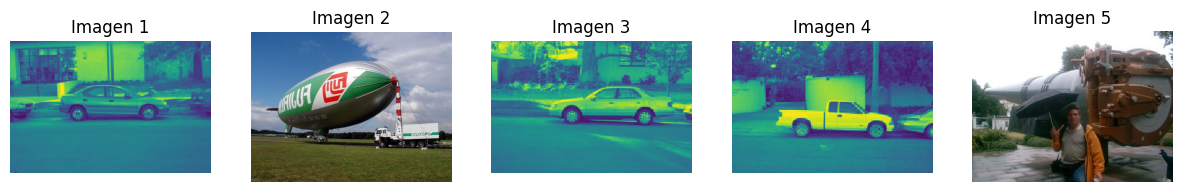

In [14]:
query_text = "big car"
sorted_image_paths = search_images_by_text(query_text, image_embeddings, image_paths)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(5):
    img = Image.open(sorted_image_paths[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {i+1}")
plt.show()
